In [533]:
# autoreload to reload modules when they change
%load_ext autoreload
%autoreload 2

import rollout
from torch import optim
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [534]:
from rollout.dataset import generate_combinations
import math 
from torch.utils.data import Dataset

class InductionValueDataset(Dataset):
    def __init__(self, num_tokens, sequence_length, random_seed=42):
        assert sequence_length <= num_tokens, "sequence_length must be less than or equal to num_tokens"

        torch.manual_seed(random_seed)
        self.num_tokens = num_tokens
        self.sequence_length = sequence_length

        
        X, y = generate_combinations(num_tokens, sequence_length, 1, return_output=True)
        self.n_samples = X.shape[0]

        self.data = X

        self.task_tokens = dict(induction=num_tokens,
                                value=num_tokens+1)
        self.labels = dict(induction=y,
                           value=torch.max(X, dim=1).values)
        # set the second half of the data to be the value task
        del X, y 

        shuffle_idx = torch.randperm(self.n_samples)

        self.n_train = int(self.n_samples * 0.8)
        self.train_idx = torch.arange(self.n_train)

        self.test_idx = torch.arange(self.n_train, self.n_samples)
        self.n_test = len(self.test_idx)
    
    def __len__(self):
        return self.n_samples
    
    def __getitem__(self, idx, task=None):
        assert task in [None, "value", "induction"], "task must be None, value, or induction. If None, a task will be randomly selected."
        if task is None:
            task = np.random.choice(["value", "induction"])
        if type(idx == int):
            n_items = 1
        else:
            n_items = len(idx)
        sample = torch.zeros(n_items, self.sequence_length + 1)
        sample[:, 1:] = self.data[idx]
        sample[:, 0] = self.task_tokens[task]
        label = self.labels[task][idx]
        
        return sample, label
    
    def generate_batch(self, batch_size, type='train', task=None):
        """
        Generates a batch of data for training or testing.
        Args:
            batch_size (int): Number of samples in the batch.
            type (str, optional): Type of data to generate ('train' or 'test'). Defaults to 'train'.
        Returns:
            tuple: A tuple containing the input sequences (X) and the output sequences (y).
        """
        #TODO: implment interleaved tasks in training
        assert task in [None, "value", "induction"], "task must be None, value, or induction. If None, a task will be randomly selected."
        
        if task is None:
            task = np.random.choice(["value", "induction"])

        assert type in ['train', 'test'], "type must be either 'train' or 'test'"
        if type == 'train':
            idx = self.train_idx[torch.randint(0, self.n_train, (batch_size,))]
        else:
            idx = self.test_idx[torch.randint(0, self.n_test, (batch_size,))]
        task_column = torch.ones(batch_size, 1, dtype=torch.long)*self.task_tokens[task]
        X = torch.cat((task_column, self.data[idx]), dim=1)
        y = self.labels[task][idx]
        return X, y
    
n_tokens = 10
sequence_length = 6
dset = InductionValueDataset(n_tokens, sequence_length)

In [535]:
def optimize_dual_model(model, criterion, optimizer, dataset, n_epochs=1000, batch_size=32):
    """
    Trains and evaluates the given model using the specified criterion and optimizer.
    Args:
        model (torch.nn.Module): The model to be trained and evaluated.
        criterion (torch.nn.Module): The loss function used to evaluate the model.
        optimizer (torch.optim.Optimizer): The optimizer used to update the model parameters.
        dataset (Dataset): The dataset object that provides training and testing data.
        n_epochs (int, optional): The number of epochs to train the model. Default is 1000.
        batch_size (int, optional): The number of samples per batch. Default is 32.
    Returns:
        tuple: A tuple containing two lists:
            - train_losses (list of float): The training loss recorded at each epoch.
            - test_losses (list of float): The testing loss recorded at each epoch.
    """
    train_losses = []
    test_losses = []
    train_task = []
    test_task = []
    for epoch in range(n_epochs):
        model.train()
        X, y = dataset.generate_batch(batch_size, type='train')
        task = X[0, 0]
        optimizer.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        train_task.append(task)
        train_losses.append(loss.item())

        model.eval()
        X, y = dataset.generate_batch(batch_size, type='test')
        task = X[0, 0]
        y_pred = model(X)
        loss = criterion(y_pred, y)
        test_losses.append(loss.item())
        test_task.append(task)

        if epoch % 100 == 0:
            print(f"Epoch {epoch}: Train Loss ({train_task[-1]}): {train_losses[-1]}, Test Loss ({test_task[-1]}): {test_losses[-1]}")
    return np.array(train_losses), np.array(test_losses), np.array(train_task), np.array(test_task)

In [539]:
d_model = 64
n_tokens = 10
max_positions = 6


dataset = InductionValueDataset(n_tokens, max_positions)


transformer2x1 = rollout.models.FlexibleTransformer(d_model, n_tokens+2, max_positions+1, 1, 2)
optimizer = optim.AdamW(transformer2x1.parameters(), lr=0.001)
criterion = nn.functional.cross_entropy

complex_train_losses, complex_test_losses, complex_train_task, complex_test_task =optimize_dual_model(transformer2x1, criterion, optimizer, dataset, n_epochs=5000, batch_size=100)

Epoch 0: Train Loss (11): 2.476763963699341, Test Loss (10): 2.8572494983673096
Epoch 100: Train Loss (11): 0.12382148951292038, Test Loss (10): 2.4795775413513184
Epoch 200: Train Loss (10): 1.706771731376648, Test Loss (11): 0.008444457314908504
Epoch 300: Train Loss (10): 1.5359115600585938, Test Loss (11): 0.02676013670861721
Epoch 400: Train Loss (11): 0.05136648565530777, Test Loss (10): 1.587674856185913
Epoch 500: Train Loss (10): 0.8131834268569946, Test Loss (11): 0.2919021546840668
Epoch 600: Train Loss (10): 0.11878561228513718, Test Loss (11): 0.23461124300956726
Epoch 700: Train Loss (11): 0.002237593289464712, Test Loss (11): 0.04170456901192665
Epoch 800: Train Loss (10): 0.003450186923146248, Test Loss (11): 0.002146250568330288
Epoch 900: Train Loss (11): 0.00029809304396621883, Test Loss (11): 0.0006657844060100615
Epoch 1000: Train Loss (10): 0.002855104161426425, Test Loss (10): 0.0011277556186541915
Epoch 1100: Train Loss (10): 0.0008675241260789335, Test Loss (10

In [540]:
d_model = 64
transformer1x1 = rollout.models.FlexibleTransformer(d_model, n_tokens+2, max_positions+1, 1, 1)
optimizer = optim.AdamW(transformer1x1.parameters(), lr=0.001)
criterion = nn.functional.cross_entropy

simple_train_losses, simple_test_losses, simple_train_task, simple_test_task =optimize_dual_model(transformer1x1, criterion, optimizer, dataset, n_epochs=5000, batch_size=100)

Epoch 0: Train Loss (11): 3.073758840560913, Test Loss (10): 2.690406560897827
Epoch 100: Train Loss (11): 0.9111016988754272, Test Loss (11): 1.0048255920410156
Epoch 200: Train Loss (11): 0.035345371812582016, Test Loss (11): 0.00986292865127325
Epoch 300: Train Loss (10): 2.0920724868774414, Test Loss (10): 2.2881946563720703
Epoch 400: Train Loss (11): 0.01225487794727087, Test Loss (11): 0.013403424993157387
Epoch 500: Train Loss (10): 2.096226215362549, Test Loss (11): 0.03620177134871483
Epoch 600: Train Loss (11): 0.00874368753284216, Test Loss (10): 2.101423501968384
Epoch 700: Train Loss (10): 2.044348955154419, Test Loss (10): 2.047300338745117
Epoch 800: Train Loss (10): 1.9167355298995972, Test Loss (11): 0.10173851996660233
Epoch 900: Train Loss (11): 0.05064493790268898, Test Loss (11): 0.27163204550743103
Epoch 1000: Train Loss (11): 0.02597872167825699, Test Loss (10): 2.0924935340881348
Epoch 1100: Train Loss (11): 0.007981565780937672, Test Loss (10): 1.9507211446762

In [541]:
def split_task_losses(task_losses, task_labels):
    task_losses = np.array(task_losses)
    task_labels = np.array(task_labels)
    task1_losses = task_losses[task_labels == 10]
    task2_losses = task_losses[task_labels == 11]
    task1_idx = np.where(task_labels == 10)[0]
    task2_idx = np.where(task_labels == 11)[0]

    return dict(induction_loss=task1_losses, value_loss=task2_losses,
                 induction_idx=task1_idx, value_idx=task2_idx)


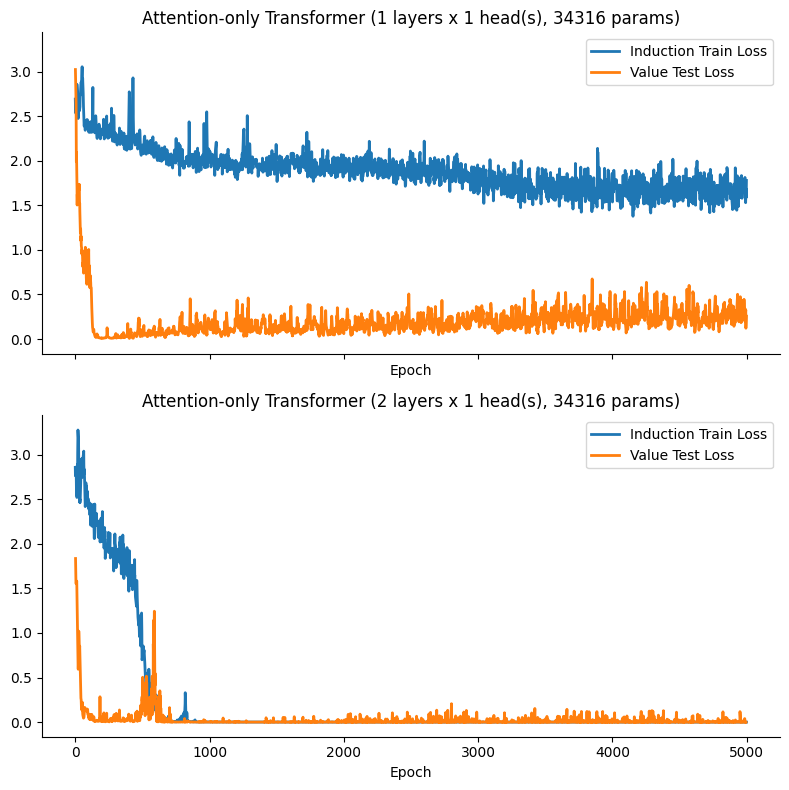

In [542]:
fig, ax = plt.subplots(2, 1, figsize=(8, 8), tight_layout=True, sharex=True, sharey=True)
def plot_losses_by_task(ax, task_losses, task_labels, title):
    res = split_task_losses(task_losses, task_labels)
    ax.plot(res["induction_idx"], res["induction_loss"], label='Induction Train Loss', linewidth=2)
    ax.plot(res["value_idx"], res["value_loss"], label='Value Test Loss', linewidth=2)
    ax.set_xlabel("Epoch")
    #x = np.arange(0, 3500, 500)
    #ax.set_xticks(x, x*50)
    #ax.set_xlim(-50, 2500)
    ax.legend()
    ax.set_title(title)

    import seaborn as sns
    sns.despine()

num_simple_params = sum(p.numel() for p in transformer2x1.parameters() if p.requires_grad)
plot_losses_by_task(ax[0], simple_test_losses, simple_test_task, f"Attention-only Transformer (1 layers x 1 head(s), {num_simple_params} params)")
num_complex_params = sum(p.numel() for p in transformer2x1.parameters() if p.requires_grad)
plot_losses_by_task(ax[1], complex_test_losses, complex_test_task, f"Attention-only Transformer (2 layers x 1 head(s), {num_complex_params} params)")

In [543]:
value_sample = dataset.__getitem__(0, task='value')
induction_sample = dataset.__getitem__(0, task='induction')


In [544]:
value_sample = dataset.generate_batch(5, type='train', task='value')

In [545]:
value_sample[0][1, :]

tensor([11,  4,  1,  0,  6,  3,  4])

In [546]:
transformer2x1(value_sample[0][0, :].unsqueeze(0))

tensor([[-3.9696, -3.3814, -7.4527, -4.8099,  0.3912,  0.1344, -1.1056, -0.7395,
         -1.7699, 17.2434, -2.7031, -3.1863]], grad_fn=<SliceBackward0>)

In [547]:
from sklearn.decomposition import PCA

In [548]:
embed_weights = transformer2x1.embed.weight.detach().numpy()

In [549]:
pca_model = PCA(n_components=12)
embed_weights_pca = pca_model.fit_transform(embed_weights)

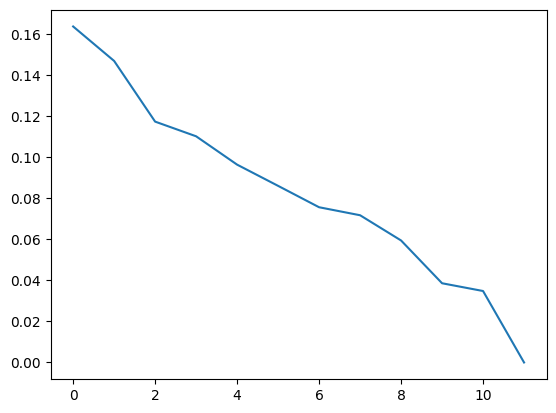

In [550]:
plt.plot(pca_model.explained_variance_ratio_)

<BarContainer object of 12 artists>

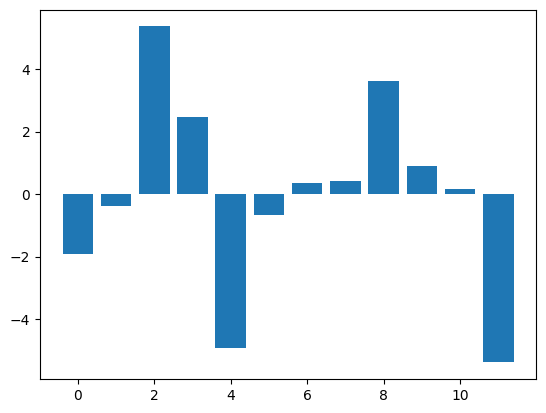

In [551]:
plt.bar(np.arange(0, 12), embed_weights_pca[:, 0])

In [616]:
#def get_attention_weights(model, sample):
X = value_sample[0][3, :].unsqueeze(0)
X_induction = X.clone()
X_induction[0][0] = X_induction[0][0] - 1
logits, value_attn_weights = transformer2x1.forward_with_weights(X)
logits, induction_attn_weights = transformer2x1.forward_with_weights(X_induction)

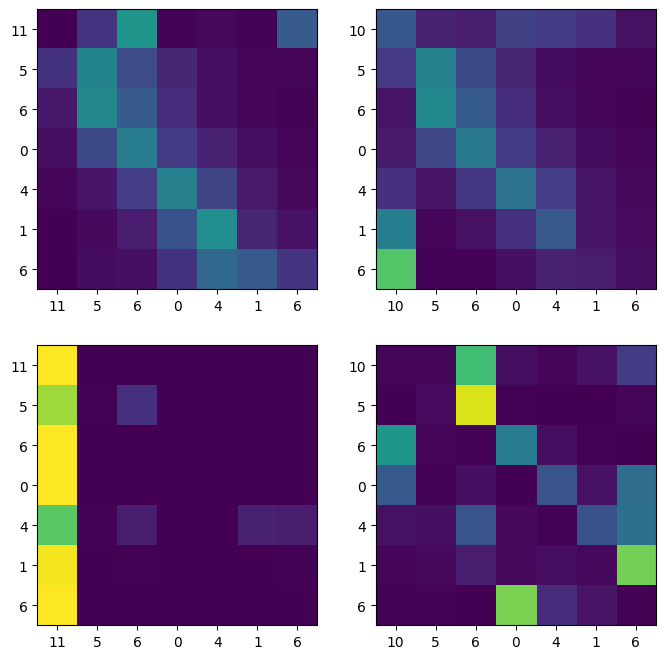

In [618]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
axis_labels = X.squeeze().detach().numpy()
for i in range(2):
    ax[i, 0].imshow(value_attn_weights[i].squeeze(), vmin=0, vmax=1)
    ax[i, 0].set_xticks(np.arange(0, 7), axis_labels)
    ax[i, 0].set_yticks(np.arange(0, 7), axis_labels)

axis_labels = X_induction.squeeze().detach().numpy()
for i in range(2):
    ax[i, 1].imshow(induction_attn_weights[i].squeeze(), vmin=0, vmax=1)
    ax[i, 1].set_xticks(np.arange(0, 7), axis_labels)
    ax[i, 1].set_yticks(np.arange(0, 7), axis_labels)

In [610]:
def get_QKV(layer, d_model):
    return dict(Q = layer.in_proj_weight[:d_model],
                K = layer.in_proj_weight[d_model:2*d_model],
                V = layer.in_proj_weight[2*d_model:3*d_model])

def embed_proj(model, X):
    X = model.embed(X)
    X = X + model.position(X)
    return X
    

res = get_QKV(transformer2x1.attention_layers[0], 64)

In [611]:
X = value_sample[0][2, :].unsqueeze(0)
X_E = embed_proj(transformer2x1, X).squeeze()

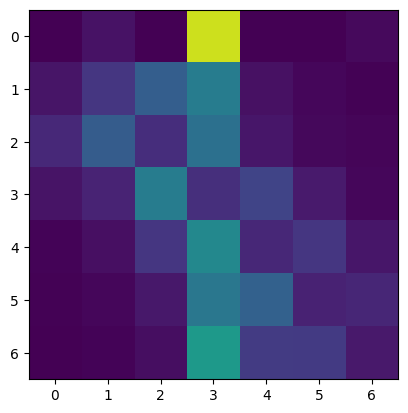

In [614]:
from torch.nn.functional import softmax
d_model = 64
plt.imshow(softmax((res["Q"] @ X_E.T).T @ (res["K"] @ X_E.T)/np.sqrt(d_model), dim=1).detach().numpy(), vmin=0, vmax=1)

In [604]:
query_task_token = res["Q"] @ X_E[0].reshape(-1, 1)
key_best_token = res["K"] @ X_E[3].reshape(-1, 1)

<BarContainer object of 64 artists>

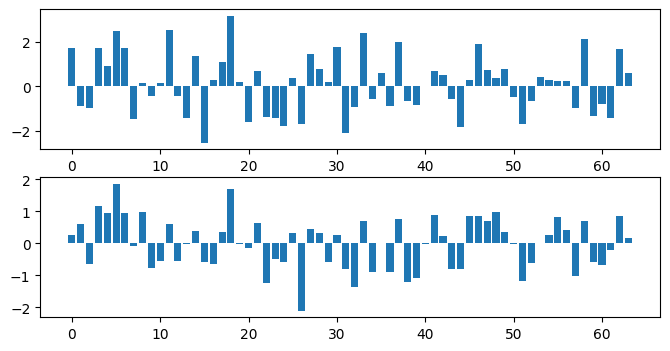

In [615]:
fig, ax = plt.subplots(2, 1, figsize=(8, 4))
ax[0].bar(np.arange(0, 64), query_task_token.detach().numpy().squeeze())
ax[1].bar(np.arange(0, 64), key_best_token.detach().numpy().squeeze())

In [606]:
query_task_token.T @ key_best_token

tensor([[51.8740]], grad_fn=<MmBackward0>)